# Classification of Sign Language with UCA-Net
## By Arda Mavi & Zeynep Dikle

### Summary:
Classification of our own 'Sign Language Dataset' with our own machine learning algorithm 'UCA-Net'

# First we look up what is autoencoder:

In [1]:
# Import
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Getting Dataset:
from get_dataset import get_dataset
X_train, X_test, Y_train, Y_test = get_dataset()

Training shape: (1649, 64, 64, 1)
1649 sample, 64 x 64 size grayscale image.

Test shape: (413, 64, 64, 1)
413 sample, 64 x 64 size grayscale image.

Examples:


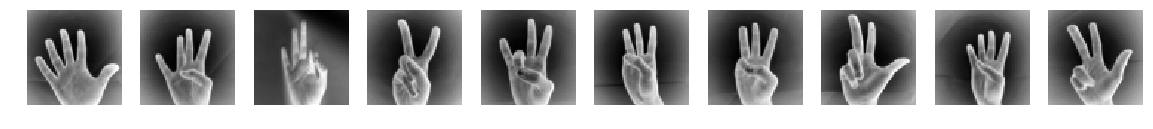

In [3]:
# About Dataset:

img_size = X_train.shape[1] # 64
channel_size = X_train.shape[3] # 1: Grayscale, 3: RGB

print('Training shape:', X_train.shape)
print(X_train.shape[0], 'sample,',X_train.shape[1] ,'x',X_train.shape[2] ,'size grayscale image.\n')
print('Test shape:', X_test.shape)
print(X_test.shape[0], 'sample,',X_test.shape[1] ,'x',X_test.shape[2] ,'size grayscale image.\n')

print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # Display some data:
    ax = plt.subplot(1, n, i)
    plt.imshow(X_train[i].reshape(img_size, img_size))
    plt.gray()
    plt.axis('off')

In [4]:
# Deep Learning Model:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from keras.models import Model

input_img = Input(shape=(img_size, img_size, channel_size))

x_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x_1 = MaxPooling2D((2, 2), padding='same')(x_1)
x_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_1)
x_1 = MaxPooling2D((2, 2), padding='same')(x_1)
x_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_1)
encoded = MaxPooling2D((2, 2), padding='same')(x_1)

x_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x_1 = UpSampling2D((2, 2))(x_1)
x_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_1)
x_1 = UpSampling2D((2, 2))(x_1)
x_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x_1)
x_1 = UpSampling2D((2, 2))(x_1)
decoded = Conv2D(channel_size, (3, 3), activation='sigmoid', padding='same')(x_1)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='rmsprop', loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 32)          0         
__________

In [5]:
# Checkpoints:
from keras.callbacks import ModelCheckpoint, TensorBoard
checkpoints = []
#checkpoints.append(TensorBoard(log_dir='/Checkpoints/logs'))

#### For training model with Data Augmentation run this cell:

# Creates live data:
# For better yield. The duration of the training is extended.

from keras.preprocessing.image import ImageDataGenerator
generated_data = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, rotation_range=0,  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip = True, vertical_flip = False)
generated_data.fit(X_train)

model.fit_generator(generated_data.flow(X_train, X_train, batch_size=batch_size), steps_per_epoch=X.shape[0], epochs=epochs, validation_data=(X_test, X_test), callbacks=checkpoints)

In [ ]:
# Training Model:
epochs = 5
batch_size = 1
autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, X_test), shuffle=True, callbacks=checkpoints)

In [ ]:
decoded_imgs = autoencoder.predict(X_test[0:11])

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # Display original:
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(img_size, img_size))
    plt.gray()
    plt.axis('off')

    # Display reconstruction:
    ax = plt.subplot(2, n, i+n)
    plt.imshow(decoded_imgs[i].reshape(img_size, img_size))
    plt.gray()
    plt.axis('off')

# Now we use autoencoder for unsupervised classification:

In [6]:
# Describe the number of classes:
num_class = 10

from keras import backend as K

# Custom classifier function:
def classifier_func(x):
    return K.sigmoid(x) #*K.one_hot(K.argmax(x, axis=1), num_classes=num_class)

In [7]:
# Deep Learning Model:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Activation, Lambda, Flatten, concatenate, Reshape
from keras.models import Model

input_img = Input(shape=(img_size, img_size, channel_size))

layer_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
layer_1 = MaxPooling2D((2, 2))(layer_1)

layer_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(layer_1)
layer_2 = MaxPooling2D((2, 2))(layer_2)

layer_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(layer_2)
layer_3 = MaxPooling2D((2, 2))(layer_3)

flat_1 = Flatten()(layer_3)

fc_1 = Dense(256)(flat_1)
fc_1 = Activation('relu')(fc_1)

fc_2 = Dense(128)(fc_1)
fc_2 = Activation('relu')(fc_2)

#Decoder:

fc_3 = Dense(256)(fc_2)
fc_3 = Activation('relu')(fc_3)

fc_4 = Dense(16384)(fc_3)
fc_4 = Activation('relu')(fc_4)

reshape_1 = Reshape((8, 8, 256))(fc_4)

layer_4 = UpSampling2D((2, 2))(reshape_1)
layer_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(layer_4)

layer_5 = UpSampling2D((2, 2))(layer_4)
layer_5 = Conv2D(128, (3, 3), activation='relu', padding='same')(layer_5)

layer_6 = UpSampling2D((2, 2))(layer_5)
layer_6 = Conv2D(64, (3, 3), activation='relu', padding='same')(layer_6)

layer_7 = Conv2D(channel_size, (3, 3), activation='sigmoid', padding='same')(layer_6)

autoencoder = Model(input_img, layer_7)
autoencoder.compile(optimizer='rmsprop', loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 256)         0         
__________

#### For training model with Data Augmentation run this cell:

In [8]:
# Getting saved mode:

autoencoder.load_weights('Data/Model/weights.h5')

In [9]:
decoded_imgs = autoencoder.predict(X_test[0:11])

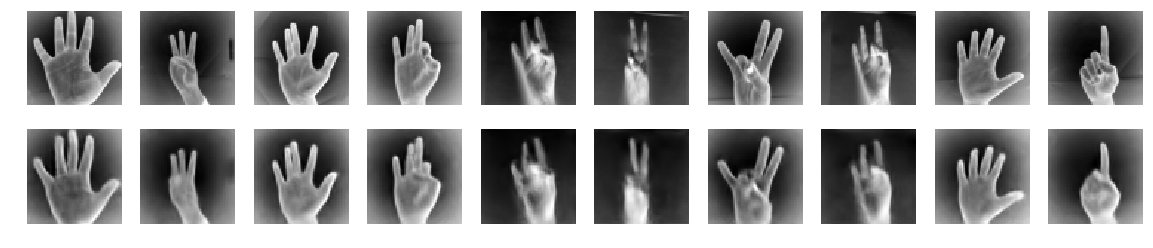

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(64, 64))
    plt.gray()
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    plt.gray()
    plt.axis('off')

In [11]:
# Split autoencoder:
encoder = Model(input_img, fc_2)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 256)         0         
__________

In [12]:
num_summary = 128

In [13]:
# Deep Learning Model:
from keras.layers import Input, Dense, Activation, Dropout
from keras.models import Model

sn_inputs = Input(shape=(2*num_summary,))

sn_fc_1 = Dense(512)(sn_inputs)
sn_fc_1 = Activation('relu')(sn_fc_1)

sn_drp_1 = Dropout(0.2)(sn_fc_1)

sn_fc_2 = Dense(256)(sn_drp_1)
sn_fc_2 = Activation('relu')(sn_fc_2)

sn_drp_2 = Dropout(0.2)(sn_fc_2)

sn_fc_3 = Dense(64)(sn_drp_2)
sn_fc_3 = Activation('relu')(sn_fc_3)

sn_fc_4 = Dense(1)(sn_fc_3)
sn_similarity_output = Activation('sigmoid')(sn_fc_4)

similarity_net = Model(sn_inputs, sn_similarity_output)
similarity_net.compile(optimizer='adadelta', loss='mse')

similarity_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

In [14]:
from keras.layers import Input, concatenate

encoder.trainable = False

dis_input_img = Input(shape=(img_size, img_size, channel_size))
dis_encoder_out = encoder(dis_input_img)

dis_input_img_2 = Input(shape=(img_size, img_size, channel_size))
dis_encoder_out_2 = encoder(dis_input_img_2)

dis_cont_1 = concatenate([dis_encoder_out, dis_encoder_out_2])

dis_output = similarity_net(dis_cont_1)
discriminator = Model([dis_input_img, dis_input_img_2], dis_output)
discriminator.compile(optimizer='adadelta', loss='mse')
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
model_3 (Model)                  (None, 128)           4597120     input_4[0][0]                    
                                                                   input_5[0][0]                    
____________________________________________________________________________________________________
concatenate_1 (Concatenate)      (None, 256)           0           model_3[1][0]           

In [15]:
from keras.preprocessing.image import ImageDataGenerator

X_train_sets = []
X_train_sets_2 = []
Y_train_sets = []

shift_size = 5
for i, image in enumerate(X_train[1:len(X_train)-3]):
    original_image = image.reshape(img_size, img_size, channel_size)

    for i_shift in [shift_size, -1*shift_size, 0]:
        for j in [0,1]:
            if i_shift == 0:
                gen_image = np.clip(original_image + 0.05 * np.random.normal(loc=0.0, scale=1.0, size=original_image.shape), 0., 1.)
            else:
                gen_image = np.roll(original_image, i_shift, axis=j)
            
            X_train_sets.append(original_image)
            X_train_sets_2.append(gen_image)
            Y_train_sets.append(1)
            if i_shift == 0:
                break
            
    for i_another_img in [1,2,0]:
        for j_another_img in [1,-1]:
            if i_another_img == 0:
                another_image = np.clip(original_image + 0.9 * np.random.normal(loc=0.0, scale=1.0, size=original_image.shape), 0., 1.)
            else:
                another_image = X_train[1+i + i_another_img*j_another_img].reshape(img_size, img_size, 1)

            X_train_sets.append(original_image)
            X_train_sets_2.append(another_image)
            Y_train_sets.append(0)
            if i_another_img == 0:
                break
X_train_sets = np.array(X_train_sets)
X_train_sets_2 = np.array(X_train_sets_2)

In [16]:
# Getting saved mode:

autoencoder.load_weights('Data/Model/weights_discriminator.h5')

In [33]:
epochs = 15
discriminator.fit([X_train_sets, X_train_sets_2], Y_train_sets, batch_size=1, epochs=epochs, shuffle=True, validation_split=0.2)

Train on 13160 samples, validate on 3290 samples
Epoch 1/3
13160/13160 [==============================] - 547s - loss: 0.0208 - val_loss: 0.0293
Epoch 2/3
13160/13160 [==============================] - 544s - loss: 0.0190 - val_loss: 0.0216
Epoch 3/3
13160/13160 [==============================] - 491s - loss: 0.0171 - val_loss: 0.0135


In [34]:
# Save Model and weights:

import os
def save_model(model):
    if not os.path.exists('Data/Model/'):
        os.makedirs('Data/Model/')
    model_json = model.to_json()
    with open("Data/Model/model_discriminator.json", "w") as model_file:
        model_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("Data/Model/weights_discriminator.h5")
    print('Model and weights saved')
    return
save_model(autoencoder)

Model and weights saved


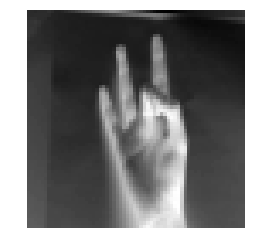

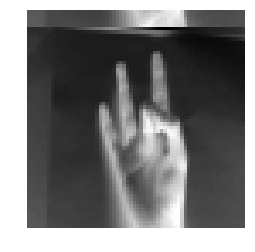

[ 0.98493308]


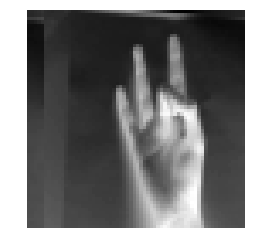

[ 0.99744689]


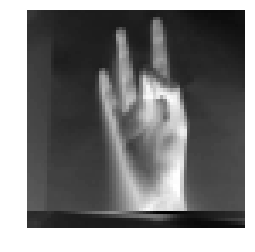

[ 0.99224299]


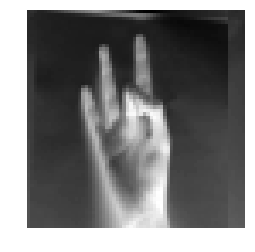

[ 0.96897942]


In [35]:
index = 8
one_simple = X_test[index].reshape(1, img_size, img_size, channel_size)

plt.gray()
plt.imshow(one_simple.reshape(img_size, img_size))
plt.axis('off')
plt.show()

shift = 5
for i in [shift, -1*shift,]:
    for j in [1, 2]:
        noise_img = np.roll(one_simple, i, axis=j)

        plt.imshow(noise_img.reshape(img_size, img_size))
        plt.axis('off')
        plt.show()

        print(discriminator.predict([one_simple, noise_img])[0])

In [57]:
discriminator.predict([X_test[1].reshape(1,64,64,1), X_test[9].reshape(1,64,64,1)])

array([[  2.39613418e-09]], dtype=float32)

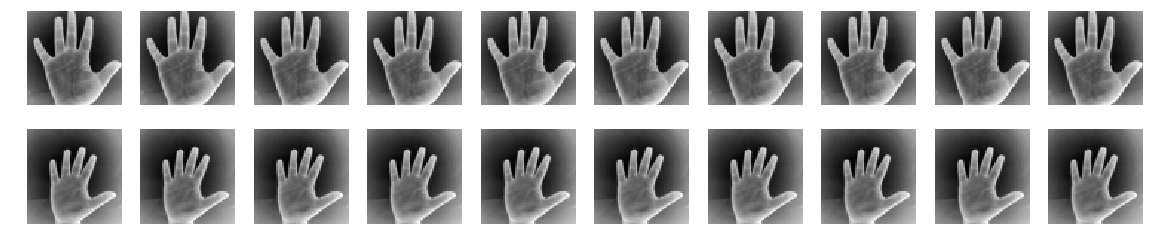

In [55]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[1].reshape(64, 64))
    plt.gray()
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(X_test[9].reshape(64, 64))
    plt.gray()
    plt.axis('off')

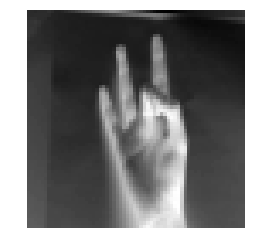

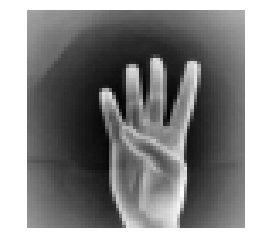

[ 0.23614152]


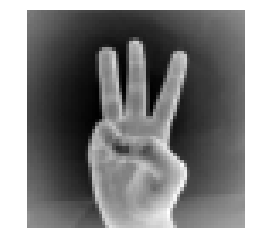

[  1.00129573e-05]


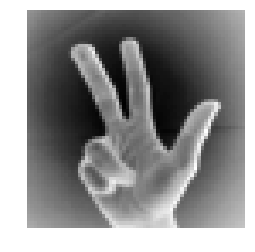

[ 0.00014822]


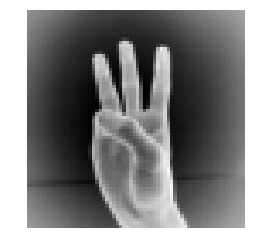

[ 0.00225931]


In [36]:
plt.gray()
index = 8
one_simple = X_test[index].reshape(1, img_size, img_size, channel_size)

plt.gray()
plt.imshow(one_simple.reshape(img_size, img_size))
plt.axis('off')
plt.show()

for i in [1,2]:
    for j in [1,-1]:
        noise_image = X_train[index + j*i].reshape(1, img_size, img_size, 1)

        plt.imshow(noise_image.reshape(img_size, img_size))
        plt.axis('off')
        plt.show()

        print(discriminator.predict([one_simple, noise_image])[0])

### Now we look up result:

0:


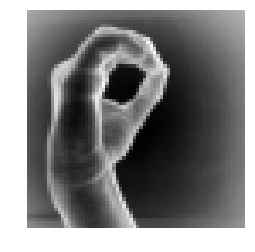

1:


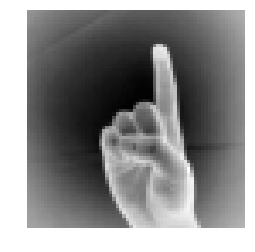

2:


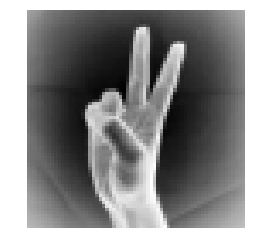

3:


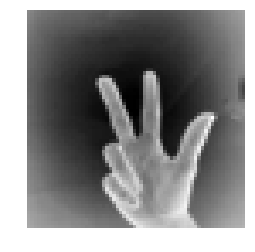

4:


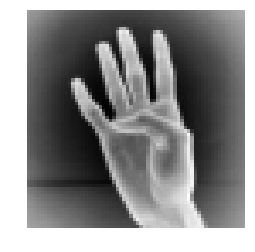

5:


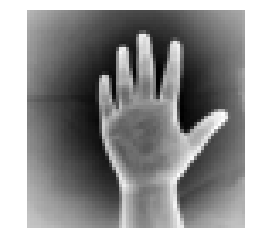

6:


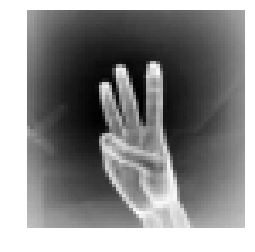

7:


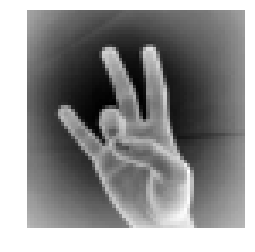

8:


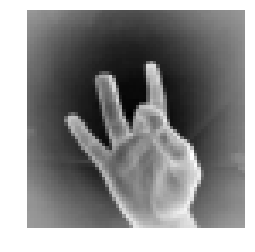

9:


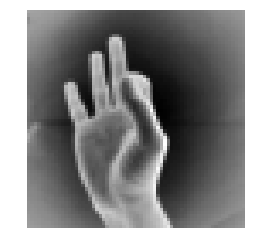

In [37]:
from os import listdir
from get_dataset import get_img

dataset_path = 'Data/Train_Data/'

data_samples = []

labels = listdir(dataset_path)
for label in range(0,10):
    datas_path = dataset_path+'/{0}'.format(label)
    img = get_img(datas_path+'/'+listdir(datas_path)[0])
    data_samples.append(img)
data_samples = 1 - np.array(data_samples).astype('float32')/255.
data_samples = data_samples.reshape(data_samples.shape[0], img_size, img_size, channel_size)

for i, img in enumerate(data_samples):
    print('{0}:'.format(i))
    plt.gray()
    plt.imshow(img.reshape(img_size, img_size))
    plt.axis('off')
    plt.show()

In [38]:
class_code = K.eval(encoder(K.variable(data_samples)))

In [39]:
encode = K.eval(encoder(K.variable(X_test)))

In [40]:
models_y_test = []
for i in encode:
    results = []
    for j in class_code:
        sim_y = similarity_net.predict(np.concatenate((i, j), axis=0).reshape(1, 256))
        results.append(sim_y[0][0])
    models_y_test.append(np.argmax(np.array(results).reshape(10), axis=0))
    
models_y_test = np.array(models_y_test)

Loss: 0.837772397094
Examples:


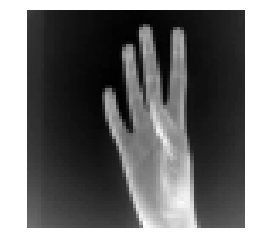

Class: 4 - Model's Output Class: 3 

 ----------------------------------------


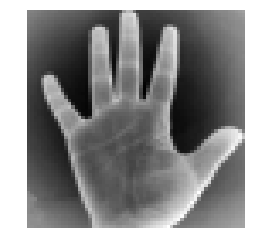

Class: 5 - Model's Output Class: 5 

 ----------------------------------------


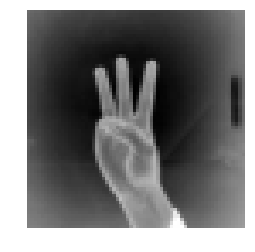

Class: 6 - Model's Output Class: 6 

 ----------------------------------------


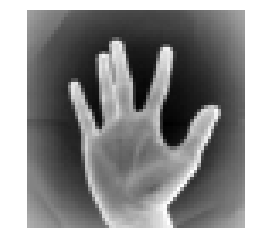

Class: 5 - Model's Output Class: 5 

 ----------------------------------------


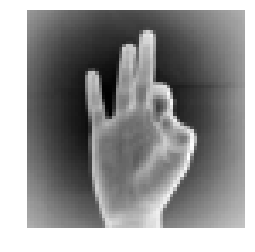

Class: 9 - Model's Output Class: 5 

 ----------------------------------------


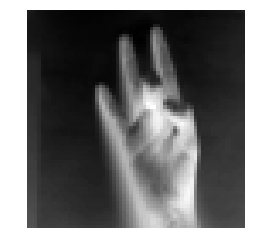

Class: 8 - Model's Output Class: 3 

 ----------------------------------------


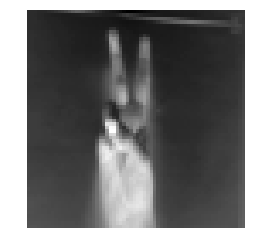

Class: 2 - Model's Output Class: 3 

 ----------------------------------------


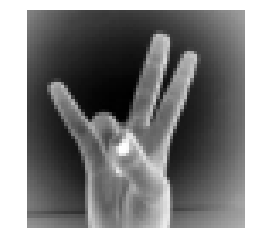

Class: 7 - Model's Output Class: 2 

 ----------------------------------------


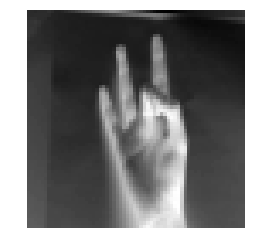

Class: 8 - Model's Output Class: 1 

 ----------------------------------------


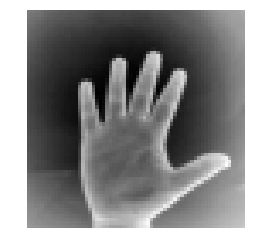

Class: 5 - Model's Output Class: 5 

 ----------------------------------------


In [41]:
num_Y_test = np.argmax(Y_test, axis=1)

comparison = models_y_test == num_Y_test
loss = 1 - np.sum(comparison.astype(int)) / num_Y_test.shape[0]

print('Loss:', loss)
print('Examples:')
for i in range(10):
    plt.imshow(X_test[i].reshape(64, 64))
    plt.gray()
    plt.axis('off')
    plt.show()
    print('Class:',  num_Y_test[i], '- Model\'s Output Class:', models_y_test[i],'\n'*2,'-'*40)

### Thank you!
#### Still in development